In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import sys
import time
import os
import random

from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
print(now_str())


[05/12 13:27:40]


In [2]:
def load_images(img_dir, img_names):
    image_refs_out = {}
    crops_out = {}
    
    w = 2160 / 2
    for img_name in img_names:
        path = img_dir + '/{}/images/undistorted'.format(img_name)
        img_paths = sorted(glob.glob(path + '/*.jpg'))
        image_refs_undistort = []
        for i, path in enumerate(img_paths):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
            image_refs_undistort.append(img)

        image_refs_cropped = []
        for i in range(len(image_refs_undistort)):
            image = image_refs_undistort[i]
            cx = image.shape[1] / 2

            image = image_refs_undistort[i]
            img = image[:, int(cx-w):int(cx+w)]
            img = cv2.resize(img, (image_size, image_size))
            image_refs_cropped.append(img)
        image_refs_out[img_name] = image_refs_undistort
        crops_out[img_name] = image_refs_cropped
    return image_refs_out, crops_out
def load_clean_plates(img_dir):
    img_paths = sorted(glob.glob(img_dir + '/*.PNG'))
    images0 = []
    images_undistort = []
    for i, path in enumerate(img_paths):
        # img = imageio.imread(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        images0.append(img)
        images_undistort.append(img)

    w = 2160 / 2
    clean_plates_cropped = []
    for i in range(len(images_undistort)):
        image = images_undistort[i]
        cx = image.shape[1] / 2

        image = images_undistort[i].astype(np.float32)
        img = image[:, int(cx-w):int(cx+w)]
        img = cv2.resize(img, (image_size, image_size))
        # img = np.dstack([img, img, img])
        clean_plates_cropped.append(img)
    
    return images0, images_undistort, clean_plates_cropped 

In [3]:
clean_plate_dir = r'D:\Pictures\2019_12_13_Lada_Capture\CleanPlates\undistorted'
img_dir = './9_data/input'
img_names = ['03052', '03990', '04917', '06950']
# img_names = ['03052']
image_size = 1080

img_refs_undistorted: dict_keys(['03052', '03990', '04917', '06950'])
  (2160, 4000)
img_refs: dict_keys(['03052', '03990', '04917', '06950'])
  (1080, 1080)
clean_plates_original: (2160, 4000)


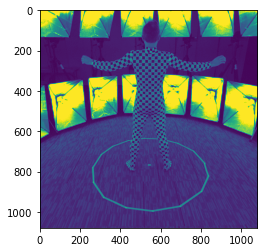

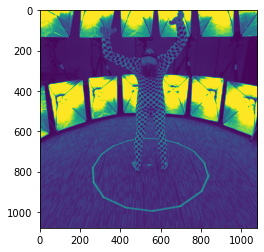

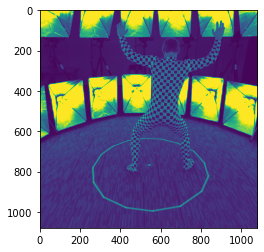

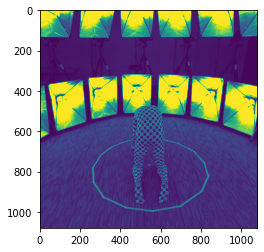

In [4]:
img_refs_undistorted, img_refs = load_images(img_dir, img_names)
print('img_refs_undistorted:', img_refs_undistorted.keys())
print('  {}'.format(img_refs_undistorted[list(img_refs_undistorted.keys())[0]][0].shape))
print('img_refs:', img_refs.keys())
print('  {}'.format(img_refs[list(img_refs.keys())[0]][0].shape))

clean_plates_original, clean_plates_undistort, clean_plates = load_clean_plates(clean_plate_dir)
print('clean_plates_original:', clean_plates_original[0].shape)

for k, v in img_refs.items():
    plt.figure()
    plt.imshow(v[0])
    plt.show()

In [5]:
print(img_refs.keys())
print(len(clean_plates))
image_refs = []

dict_keys(['03052', '03990', '04917', '06950'])
16


# Setting

In [19]:
cam_idx = 8
image_name = '06950'

src = img_refs[image_name][cam_idx]
src = (src*255.0).astype(np.uint8)
src = np.dstack([src, src, src])
print(src.shape, src.dtype, np.max(src))

(1080, 1080, 3) uint8 255


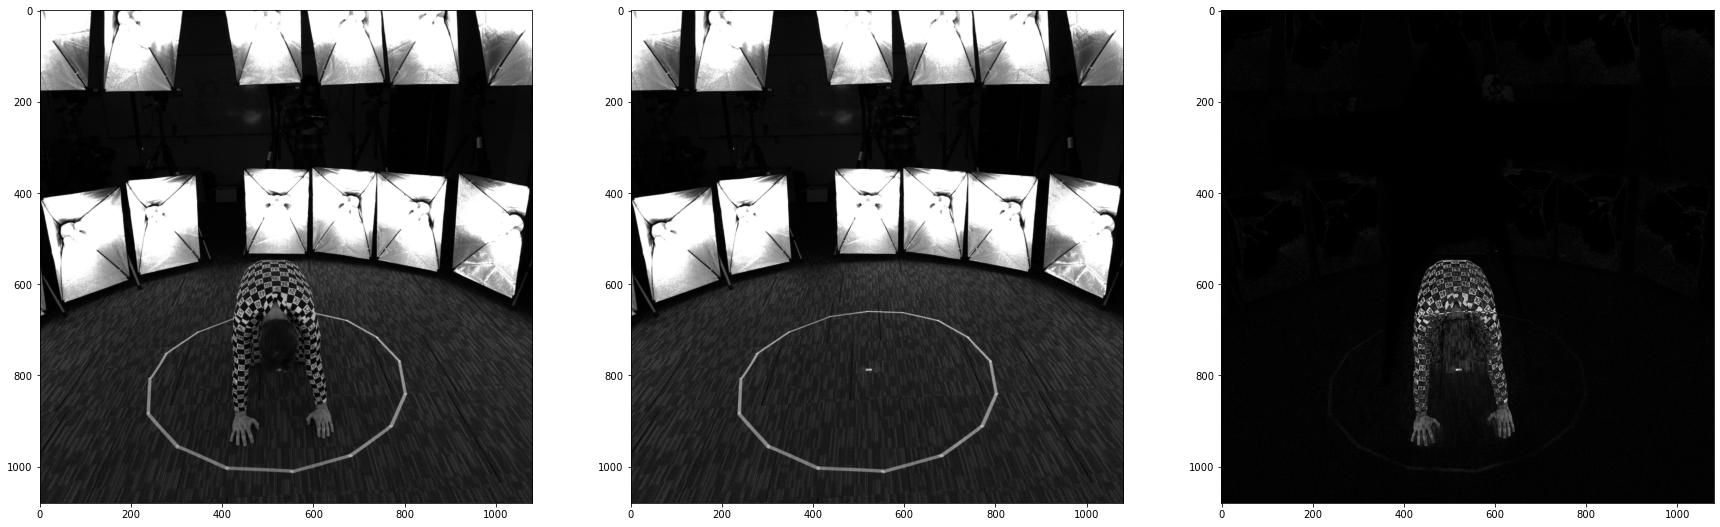

1.0


In [20]:
image_original = img_refs[image_name][cam_idx]
bg = clean_plates[cam_idx]
diff = image_original-bg
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(image_original, cmap='gray')
ax[1].imshow(bg, cmap='gray')
ax[2].imshow(np.abs(diff), cmap='gray')
plt.show()

print(np.max(image_original))

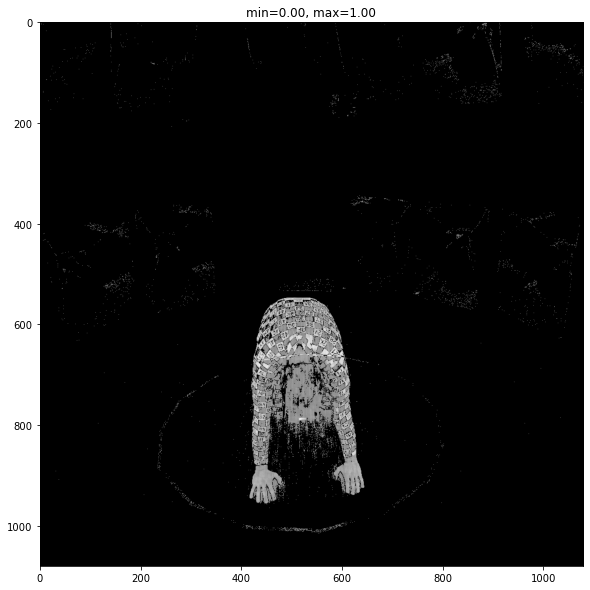

In [21]:
diff2 = np.abs(diff)
diff2 = (diff2 - np.min(diff2)) / (np.max(diff2) - np.min(diff2))
diff2 = np.where(diff2 > 0.075, diff2+1.0, diff2**2)
diff2 = (diff2 - np.min(diff2)) / (np.max(diff2) - np.min(diff2))
plt.figure(figsize=(10, 10))
plt.imshow(diff2, cmap='gray')
plt.title('min={:.2f}, max={:.2f}'.format(np.min(diff2), np.max(diff2)))
plt.show()

# Semgentation

In [22]:
# img_names
img_names = ['06950']
# cam_idx
cam_indices = [8]
print(cam_indices)
# binarize
binarize_type = ['thres', 'adaptive_mean', 'adaptive_gaussian', 'otsu', 'blur_otsu']
binary_thres = [10, 50]
adaptive_mean_winsize = [7, 11, 21]
minus_c = [0, 2, 4]

# blur
blur_type = ['median', 'gaussian']
blur_winsize = [5, 11, 21]

# edge detection
edge_detection_type = ['ml']

params = []
for img_name in img_names:
    for v0 in cam_indices:
        for v7 in edge_detection_type:
            for v1 in binarize_type:
                for v2 in binary_thres:
                    for v3 in adaptive_mean_winsize:
                        for v4 in minus_c:
                            for v5 in blur_type:
                                for v6 in blur_winsize:
                                        p = {
                                            'img_name': img_name,
                                            'cam_idx': v0,
                                            'binary_type': v1,
                                            'binary_thres': v2,
                                            'adaptive_mean_winsize': v3,
                                            'minus_c': v4,
                                            'blur_type': v5,
                                             'blur_winsize': v6,
                                             'edge_detection_type': v7
                                            }
                                        params.append(p)
print(len(params), 'settings')

[8]
540 settings


In [23]:
def params2string(idx, n_settings, p):
    str_out = '--- [Setting {}/{}] ----------------------\n'.format(idx + 1, n_settings)
    i = 1
    for k, v in p.items():
        if type(v) == str:
            str_out += '{:>2}. {:20}= {}'.format(i, k, v)
        elif isinstance(v, int):
            str_out += '{:>2}. {:20}= {:d}'.format(i, k, v)
        else:
            str_out += '{:>2}. {:20}= {:.4f}'.format(i, k, v)
        str_out += '\n'
        i += 1
    str_out += '\n'
    return str_out
def render_images(out_dir, idx, imgs, param_str):
    n_imgs = len(imgs.keys()) + 1
    c = 3
    r = n_imgs // c
    if n_imgs % c > 0:
        r += 1
    
    fig, ax = plt.subplots(r, c, figsize=(6*c, 6*r), tight_layout=True)
    ax = ax.ravel()
    ax[0].text(0.1, 1, param_str, fontsize=16, horizontalalignment='left', verticalalignment='top')
    ax[0].axis('off')
    
    i = 1
    for k, v in imgs.items():
        if len(v.shape) == 2:
            ax[i].imshow(v.astype(np.uint8), cmap='gray')
        else:
            ax[i].imshow(v.astype(np.uint8))
        ax[i].set_title('({}) {} | {} | {} | [{}, {}]'.format(i+1, k, v.shape, v.dtype, np.min(v), np.max(v)))
        i += 1
        
    out_path = out_dir + '/plot_{}.png'.format(idx)
    plt.savefig(out_path, dpi=150)
    plt.close('all')
    img = cv2.imread(out_path)
    return img

In [24]:
def get_image(img_name, cam_idx):
    global clean_plates, img_refs
    image_original = img_refs[img_name][cam_idx]
    bg = clean_plates[cam_idx]
    diff = image_original-bg
    
    diff2 = np.abs(diff)
    diff2 = (diff2 - np.min(diff2)) / (np.max(diff2) - np.min(diff2))
    diff2 = np.where(diff2 > 0.075, diff2+1.0, diff2**2)
    diff2 = (diff2 - np.min(diff2)) / (np.max(diff2) - np.min(diff2))
    diff_8uc1 = (diff2*255.0).astype(np.uint8)
    return image_original, diff_8uc1
def findSignificantContour(edgeImg):
    contours, hierarchy = cv2.findContours(
        edgeImg,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )
     # Find level 1 contours
    level1Meta = []
    if hierarchy is None:
        print('* hierarchy is None')
        largestContour = None
    else:
        for contourIndex, tupl in enumerate(hierarchy[0]):
            # Each array is in format (Next, Prev, First child, Parent)
            # Filter the ones without parent
            if tupl[3] == -1:
                tupl = np.insert(tupl.copy(), 0, [contourIndex])
                level1Meta.append(tupl)
         # From among them, find the contours with large surface area.
        contoursWithArea = []
        for tupl in level1Meta:
            contourIndex = tupl[0]
            contour = contours[contourIndex]
            area = cv2.contourArea(contour)
            contoursWithArea.append([contour, area, contourIndex])
        contoursWithArea.sort(key=lambda meta: meta[1], reverse=True)
        largestContour = contoursWithArea[0][0]
    return largestContour

def binarizer(image, p):
    binary_type = p['binary_type']
    if binary_type == 'thres':
        binary_thres = p['binary_thres']
        _, img1 = cv2.threshold(image, binary_thres, 255, cv2.THRESH_BINARY)
    elif binary_type == 'adaptive_mean':
        winsize = p['adaptive_mean_winsize']
        c = p['minus_c']
        img1 = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, winsize, c)
        img1 = 255 - cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, winsize, c)
    elif binary_type == 'adaptive_gaussian':
        winsize = p['adaptive_mean_winsize']
        c = p['minus_c']
        img1 = 255 - cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, winsize, c)
    elif binary_type == 'otsu':
        _, img1 = cv2.threshold(image, 0, 255, cv2. THRESH_BINARY + cv2.THRESH_OTSU)
    elif binary_type == 'blur_otsu':
        img1 = cv2.GaussianBlur(image, (5, 5), 0)
        _, img1 = cv2.threshold(img1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        assert(False)
    return img1
def blurer(image, p):
    blur_type = p['blur_type']
    blur_winsize = p['blur_winsize']
    if blur_type == 'median':
        out = cv2.medianBlur(image, blur_winsize)
    elif blur_type == 'gaussian':
        out = cv2.GaussianBlur(image, (blur_winsize, blur_winsize), 1)
    else:
        assert(False)
    return out
def edge_detector(image, p):
    edge_detection_type = p['edge_detection_type']
    if edge_detection_type == 'sobel':
        sobelX = cv2.Sobel(image, cv2.CV_16S, 1, 0)
        sobelY = cv2.Sobel(image, cv2.CV_16S, 0, 1)
        out = np.hypot(sobelX, sobelY)
        out[out > 255] = 255; # Some values seem to go above 255. However RGB channels has to be within 0-255
    elif edge_detection_type == 'ml':
        edgeDetector = cv2.ximgproc.createStructuredEdgeDetection(r"D:\1_Projects\200325_PyTorch3d_Toy\17_data\input\model.yml")
        img = np.dstack([image, image, image]).astype(np.float32) / 255.0
        out = edgeDetector.detectEdges(img)
        out = out * 255
    else:
        assert(False)

    return out.astype(np.uint8)

def contour_finder(image):
    """
    image: must be 8uc1
    """
    img = image.astype(np.uint8)
    contours, hierarchy = cv2.findContours(
        img,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )
     # Find level 1 contours
    level1Meta = []
    for contourIndex, tupl in enumerate(hierarchy[0]):
        # Each array is in format (Next, Prev, First child, Parent)
        # Filter the ones without parent
        if tupl[3] == -1:
            tupl = np.insert(tupl.copy(), 0, [contourIndex])
            level1Meta.append(tupl)
     # From among them, find the contours with large surface area.
    contoursWithArea = []
    for tupl in level1Meta:
        contourIndex = tupl[0]
        contour = contours[contourIndex]
        area = cv2.contourArea(contour)
        contoursWithArea.append([contour, area, contourIndex])
    contoursWithArea.sort(key=lambda meta: meta[1], reverse=True)
    largestContour = contoursWithArea[0][0]
    return largestContour

def gen_trimap(image, contour):
    mask = np.zeros_like(image).astype(np.uint8)
    cv2.fillPoly(mask, [contour], 255)

    # calculate sure foreground area by dilating the mask
    mapFg = cv2.erode(mask, np.ones((5, 5), np.uint8), iterations=10)
    # mark inital mask as "probably background"
    # and mapFg as sure foreground
    trimap = np.copy(mask)
    trimap[mask == 0] = cv2.GC_BGD
    trimap[mask == 255] = cv2.GC_PR_BGD
    trimap[mapFg == 255] = cv2.GC_FGD
    return trimap

def grab_cut(image, trimap):
    """
    image: must be CV_8UC3
    mask: must be CV_8UC1
    """
    mask = np.zeros(image.shape, np.uint8)
    
    # used internally. don't change
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    
    # where fg is located in (x, y, h, w)
    rect = (0, 0, mask.shape[0] - 1, mask.shape[1] - 1)
#     print('  image:', image.shape, image.dtype, np.min(image), np.max(image))
#     print('  trimap:', trimap.shape, trimap.dtype, np.min(trimap), np.max(trimap))
#     print('  rect:', rect)
    try:
        cv2.grabCut(image, trimap, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)
    except:
        print('* cv2.grabCut error')
        pass

    out = np.where(
        (trimap == cv2.GC_FGD) | (trimap == cv2.GC_PR_FGD),
        255,
        0
    ).astype('uint8')
    return out
def draw_contour(image, contour):
    """
    image: float 1.0
    """
    # Draw the contour on the original image
    contour_img = np.copy(image*255)
    contour_img = np.dstack([contour_img, contour_img, contour_img]).astype(np.uint8)
    cv2.drawContours(contour_img, [contour], 0, (255, 0, 0), 2, cv2.LINE_AA, maxLevel=1)
    return contour_img

In [25]:
def find_contour(image_original, image, f, p):
    """
    image: uint8, 255
    """
    img_out = {}
    aux = {}
    # binary
    img = f['binarizer'](image, p)
    img_out['binary'] = img.copy() # 8UC1
    
    # blur1
    img = f['blurer'](img, p)
    img_out['blur1'] = img.copy() # 8UC1
    
    # edge detection
    img = f['edge_detector'](img, p)
    img_out['edge_detection'] = img.copy() # 8UC1
    
    # blur2
#     img4 = f['blurer'](img3, p)
#     img_out['blur2'] = img4 # 8UC1

    # contour
    contour = f['contour_finder'](img)
    aux['contour'] = contour
        
    # Draw the contour on the original image
    contour_img = draw_contour(image_original, contour)
    img_out['contour_img'] = contour_img
    
    # trimap
    trimap = f['trimap'](img, contour)
    # visualize trimap
    trimap_print = np.copy(trimap)
    trimap_print[trimap_print == cv2.GC_PR_BGD] = 128
    trimap_print[trimap_print == cv2.GC_FGD] = 255
    img_out['trimap_viz'] = trimap_print
    
    # graph-cut
    img = np.dstack([img, img, img]).astype(np.uint8)
    grabcut = f['grabcut'](img, trimap)
    img_out['grabcut'] = grabcut
    
    # segment
    contour2 = findSignificantContour(grabcut)
    if contour2 is None:
        print('* output from "findSignificantContour" is None')
    else:
        contour_img2 = draw_contour(image_original, contour2)
        img_out['contour_img2'] = contour_img2
        mask3 = np.zeros_like(grabcut)
        cv2.fillPoly(mask3, [contour2], 255)
        # blended alpha cut-out
        mask3 = np.repeat(mask3[:, :, np.newaxis], 3, axis=2)
        mask4 = cv2.GaussianBlur(mask3, (3, 3), 0)
        alpha = mask4.astype(float) * 1.1  # making blend stronger
        alpha[mask3 > 0] = 255
        alpha[alpha > 255] = 255
        alpha = alpha.astype(float)

        image_original_c3 = np.dstack([image_original, image_original, image_original])
        foreground = np.copy(image_original_c3).astype(float)
        foreground[mask4 == 0] = 0
        background = np.ones_like(foreground, dtype=float) * 255

        # Normalize the alpha mask to keep intensity between 0 and 1
        alpha = alpha / 255.0
        # Multiply the foreground with the alpha matte
        foreground = cv2.multiply(alpha, foreground)
        # Multiply the background with ( 1 - alpha )
        background = cv2.multiply(1.0 - alpha, background)
        # Add the masked foreground and background.
        cutout = cv2.add(foreground, background)

        img_out['cutout'] = cutout
    return img_out, aux

out_dir = './17b_data/output'

now = datetime.now()
date_str = '{}{:>02}{:>02}'.format(now.year, now.month, now.day)
log_path = out_dir + '/log_{}.txt'.format(date_str)


f = {}
f['binarizer'] = binarizer
f['blurer'] = blurer
f['edge_detector'] = edge_detector
f['contour_finder'] = contour_finder
f['trimap'] = gen_trimap
f['grabcut'] = grab_cut
t_start = time.time()
log_str = 'start: {}'.format(len(params))
print(log_str)
__output_log(log_path, log_str + '\n')
for i in range(len(params)):
    if i < 431:
        continue
    t0 = time.time()

    p = params[i]
    image_in, diff = get_image(p['img_name'], p['cam_idx'])
    img_out, _ = find_contour(image_in, diff, f, p)
    t1 = time.time()
    
    log_str = '  {} {}/{} {:.2f}s | {}.pgm, cam={}'.format(now_str(), i+1, len(params), t1-t0, p['img_name'], p['cam_idx'])
    print(log_str)
    __output_log(log_path, log_str + '\n')

    param_str = params2string(i, len(params), params[i])
    _ = render_images(out_dir, i, img_out, param_str)
    del img_out
    break
print()
log_str = '{} Done: {:.2f}s'.format(now_str(), time.time()-t_start)
print(log_str)
__output_log(log_path, log_str + '\n')

start: 540
  [05/12 16:45:21] 432/540 3.08s | 06950.pgm, cam=8

[05/12 16:45:23] Done: 4.96s


In [ ]:


out_dir = './17b_data/output'
i = 0
param_str = params2string(i, len(params), params[i])
plot = render_images(out_dir, i, imgs_out[i], param_str)
plt.figure() 
plt.imshow(plot)
plt.show()

In [ ]:
# img = cv2.medianBlur((diff2*255.0).astype(np.uint8), 3)
img = (diff2*255.0).astype(np.uint8)

thres_val = 5
# global thresholding
ret1,th1 = cv2.threshold(img, thres_val, 255, cv2.THRESH_BINARY)
# adaptive mean
win_size = 11
minus_C = 4
th2 = 1.0-cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, win_size, minus_C)
# adaptive gaussian
th3 = 1.0-cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, win_size, minus_C)
# Otsu's thresholding
ret4, th4 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret5, th5 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

titles = ['Original Image', 'Global Thresholding {}'.format(thres_val), 'Adaptive Mean Thresholding (window={}, C={})'.format(win_size, minus_C), 'Adaptive Gaussian Thresholding (window={}, C={})'.format(win_size, minus_C), "Otsu's Thresholding", "Blur + Otsu's Thresholding"]
images = [img, th1, th2, th3, th4, th5]

fig, ax = plt.subplots(3, len(images) // 3, figsize=(15*(len(images) // 3), 12*3))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('{}, {}, max={}'.format(images[i].shape, images[i].dtype, np.max(images[i])))
plt.show()

In [ ]:
import numpy as np
import cv2
def edgedetect(channel):
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255; # Some values seem to go above 255. However RGB channels has to be within 0-255
    return sobel
    

edges = []
edges2 = [] # for comparisons
for i in range(len(images)):
    img = images[i]
    
    blurred = cv2.GaussianBlur(img, (7, 7), 0)
    blurred_float = blurred.astype(np.float32) / 255.0

#     edgeDetector = cv2.ximgproc.createStructuredEdgeDetection(r"D:\1_Projects\200325_PyTorch3d_Toy\17_data\input\model.yml")
#     edge = edgeDetector.detectEdges(blurred_float) * 255.0


    edge = edgedetect(blurred_float)
    edges.append(edge.copy())
    
    mean = np.mean(edge)
    # Zero any value that is less than mean. This reduces a lot of noise.
    edge[edge <= mean] = 0
    edges2.append(edge.copy())

fig, ax = plt.subplots(1, len(images), figsize=(10*len(images), 20))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(edges[i], cmap='gray')
    ax[i].set_title(titles[i])
plt.show()

In [ ]:
def filterOutSaltPepperNoise(edgeImg, winsize):
    # Get rid of salt & pepper noise.
    count = 0
    lastMedian = edgeImg
    median = cv2.medianBlur(edgeImg, winsize)
    while not np.array_equal(lastMedian, median):
        # get those pixels that gets zeroed out
        zeroed = np.invert(np.logical_and(median, edgeImg))
        edgeImg[zeroed] = 0

        count = count + 1
        if count > 70:
            break
        lastMedian = median
        median = cv2.medianBlur(edgeImg, 3)
        
edges_8u = []
for i in range(len(edges)):
    edge = edges[i]
    edge_8u = np.asarray(edge, np.uint8)
    filterOutSaltPepperNoise(edge_8u, 3)
    edges_8u.append(edge_8u)
    
    
fig, ax = plt.subplots(1, len(images), figsize=(10*len(images), 10))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(edges_8u[i], cmap='gray')
    ax[i].set_title(titles[i])
plt.show()

In [ ]:
def findSignificantContour(edgeImg):
    contours, hierarchy = cv2.findContours(
        edgeImg,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )
     # Find level 1 contours
    level1Meta = []
    if hierarchy is None:
        print('findSignificantContour: heirachy=', hierachy)
        largestContour = None
    else:
        for contourIndex, tupl in enumerate(hierarchy[0]):
            # Each array is in format (Next, Prev, First child, Parent)
            # Filter the ones without parent
            if tupl[3] == -1:
                tupl = np.insert(tupl.copy(), 0, [contourIndex])
                level1Meta.append(tupl)
         # From among them, find the contours with large surface area.
        contoursWithArea = []
        for tupl in level1Meta:
            contourIndex = tupl[0]
            contour = contours[contourIndex]
            area = cv2.contourArea(contour)
            contoursWithArea.append([contour, area, contourIndex])
        contoursWithArea.sort(key=lambda meta: meta[1], reverse=True)
        largestContour = contoursWithArea[0][0]
    return largestContour

contour_imgs = []
contours = []
for i in range(len(edges_8u)):
    edge_8u = edges_8u[i]
    contour = findSignificantContour(edge_8u)
    contours.append(contour)
    
    # Draw the contour on the original image
    contourImg = np.copy(images[0])
    contourImg = np.dstack([contourImg, contourImg, contourImg])
    cv2.drawContours(contourImg, [contour], 0, (255, 0, 0), 2, cv2.LINE_AA, maxLevel=1)
    contour_imgs.append(contourImg)

fig, ax = plt.subplots(1, len(images), figsize=(10*len(images), 10))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(contour_imgs[i])
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(contour_imgs[i].shape)
plt.show()

In [ ]:
trimaps = []
masks = []
for i in range(len(edges_8u)):
    edge_8u = edges_8u[i]
    mask = np.zeros_like(edge_8u)
    
    contour = contours[i]
    print('fillPoly:', mask.shape, mask.dtype, np.min(mask), np.max(mask))
    cv2.fillPoly(mask, [contour], 255)

    # calculate sure foreground area by dilating the mask
    mapFg = cv2.erode(mask, np.ones((5, 5), np.uint8), iterations=10)
    
    # mark inital mask as "probably background"
    # and mapFg as sure foreground
    trimap = np.copy(mask)
    trimap[mask == 0] = cv2.GC_BGD
    trimap[mask == 255] = cv2.GC_PR_BGD
    trimap[mapFg == 255] = cv2.GC_FGD

    # visualize trimap
    trimap_print = np.copy(trimap)
    trimap_print[trimap_print == cv2.GC_PR_BGD] = 128
    trimap_print[trimap_print == cv2.GC_FGD] = 255
    trimaps.append(trimap)
    masks.append(mask)

fig, ax = plt.subplots(1, len(images), figsize=(10*len(images), 10))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(trimaps[i], cmap='gray')
    ax[i].set_title(titles[i])
plt.show()

In [ ]:
# run grabcut
grabcuts = []
for i in range(len(trimaps)):
    src1 = images[i].astype(np.uint8)
    src1 = np.dstack([src1, src1, src1])
    trimap = trimaps[i]
    mask2 = masks[i]
    
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (0, 0, mask2.shape[0] - 1, mask2.shape[1] - 1)
    
    cv2.grabCut(src1, trimap, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)

    # create mask again
    mask3 = np.where(
        (trimap == cv2.GC_FGD) | (trimap == cv2.GC_PR_FGD),
        255,
        0
    ).astype('uint8')
    grabcuts.append(mask3)

fig, ax = plt.subplots(1, len(images), figsize=(10*len(images), 10))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(grabcuts[i], cmap='gray')
    ax[i].set_title(titles[i])
plt.show()

In [ ]:
fgs = []
bgs = []
alphas = []
cutouts = []

for i in range(len(grabcuts)):
    mask = grabcuts[i]
    contour = findSignificantContour(mask)
    mask3 = np.zeros_like(mask)
    cv2.fillPoly(mask3, [contour], 255)
    
    # blended alpha cut-out
    mask3 = np.repeat(mask3[:, :, np.newaxis], 3, axis=2)
    mask4 = cv2.GaussianBlur(mask3, (3, 3), 0)
    alpha = mask4.astype(float) * 1.1  # making blend stronger
    alpha[mask3 > 0] = 255
    alpha[alpha > 255] = 255
    alpha = alpha.astype(float)

    image_original_c3 = np.dstack([image_original, image_original, image_original])
    foreground = np.copy(image_original_c3).astype(float)
    foreground[mask4 == 0] = 0
    background = np.ones_like(foreground, dtype=float) * 255

    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha / 255.0
    # Multiply the foreground with the alpha matte
    foreground = cv2.multiply(alpha, foreground)
    # Multiply the background with ( 1 - alpha )
    background = cv2.multiply(1.0 - alpha, background)
    # Add the masked foreground and background.
    cutout = cv2.add(foreground, background)

    fgs.append(foreground)
    bgs.append(background)
    alphas.append(alpha)
    cutouts.append(cutout)

for i in range(len(cutouts)):
    fig, ax = plt.subplots(1, 5, figsize=(50, 10))
    ax[0].imshow(grabcuts[i], cmap='gray')
    ax[0].set_title('mask')
    
    ax[1].imshow(fgs[i], cmap='gray')
    ax[1].set_title('foreground')
    
    ax[2].imshow(bgs[i], cmap='gray')
    ax[2].set_title('background')
    
    ax[3].imshow(alphas[i], cmap='gray')
    ax[3].set_title('alpha')
    
    ax[4].imshow(cutouts[i], cmap='gray')
    ax[4].set_title('cutout')
    plt.show()